In [38]:
# Sanaâ MOUSSA

In [261]:
# A décommenter à la première exécution si jupyter se plaint de ne pas trouver oracledb
!pip install --upgrade oracledb

In [262]:
# Compléter ici les imports dont vous avez besoin, ne pas modifier ceux déjà présents
import getpass
from os import getenv
import pandas as pd
import oracledb
import warnings
import matplotlib.pyplot as plt

In [263]:
# La fonction ci-dessous est à utiliser pour exécuter une requête et stocker les résultats dans un dataframe Pandas sans afficher d’alerte.
# Vous pouvez vous en inspirer pour créer vos propres fonctions.
def requete_vers_dataframe(connexion, requete, valeurs = None):
    warnings.simplefilter(action='ignore', category=UserWarning)
    if valeurs is not None:
        df = pd.read_sql(requete, connexion, params=valeurs)
    else:
        df = pd.read_sql(requete, connexion)
    warnings.simplefilter("always") 
    return df

In [264]:
# Saisir ci-dessous l'édition des JO qui vous a été attribuée. Cela correspond au LibelleHote dans la table HOTE de la base de données
# Par exemple EDITION_JO = "2020 Summer Olympics"
EDITION_JO = "2006 Winter Olympics"
# Saisir ci-dessous le login court de la base utilisée pour votre carnet
SCHEMA = "NVOUILL"

In [265]:
# On demande à l'utilisateur son login et mot de passe pour pouvoir accéder à la base de données
if getenv("DB_LOGIN") is None:
    login = input("Login : ")
else:
    login = getenv("DB_LOGIN")
if getenv("DB_PASS") is None:
    password = getpass.getpass("Mot de passe : ")
else:
    password = getenv("DB_PASS_PASS")
conn = oracledb.connect(user=login, password=password, host="oracle.iut-orsay.fr", port=1521, sid="etudom")
conn.autocommit = False

Login :  nvouill
Mot de passe :  ········


In [266]:
# On vérifie que l'utilisateur est bien connecté à la base de données et qu'on trouve la bonne édition des JO
data = requete_vers_dataframe(conn, f"SELECT * FROM {SCHEMA}.HOTE WHERE LibelleHote LIKE (:libelle)",{"libelle":EDITION_JO})
id_hote = int(data.IDHOTE.iloc[0])
print(f"Identifiant de l’hôte : {id_hote}")

Identifiant de l’hôte : 49


# **Présentation des Winter Olympic de 2006:**
## Projet BD 2024
### Réaliser par MOUSSA Sanaa - HACHMI Yousra - VOUILLOUX Nicolas

* Ville d'accueil
    * Turin
* Pays d'accueil 
    * Italie

Date Ouverture - 10 Fervrier  
Date Fermeture - 26 Fevrier  
Dates Competition 11-26 Fevrier

### Autres épreuves héberger en Italie:
* Jeux D'hiver 1986 à Cortina d'Ampezzo
* Jeux D'été 1960 à Rome

# TABLEAU DE BORD DES JO

## Partie consultation des données

### Les épreuves

In [267]:
data_evenements = requete_vers_dataframe(
    conn, 
    f"SELECT IDEVENEMENT, NOMEVENEMENT, CODEDISCIPLINE "
    f"FROM {SCHEMA}.EVENEMENT "
    f"WHERE IDHOTE = 49"
)
data_evenements.iloc[0:84]




,IDEVENEMENT,NOMEVENEMENT,CODEDISCIPLINE
0,1502,"Downhill, Women",ALP
1,1503,"Super G, Women",ALP
2,2134,"50 kilometres, Men",CCS
3,1487,"Downhill, Men",ALP
4,1496,"Combined, Men",ALP
...,...,...,...
79,2130,"15 kilometres, Men",CCS
80,2131,"30 kilometres Skiathlon, Men",CCS
81,2461,"Normal Hill, Individual, Men",SJP
82,2667,"Curling, Men",CUR


### Les sports

In [268]:
data_sports = requete_vers_dataframe(
    conn, 
    f"SELECT DISTINCT NOMSPORT AS \"Nom du Sport\" "
    f"FROM {SCHEMA}.SPORT S "
    f"INNER JOIN {SCHEMA}.DISCIPLINE D ON S.CODESPORT = D.CODESPORT "
    f"INNER JOIN {SCHEMA}.EVENEMENT E ON D.CODEDISCIPLINE = E.CODEDISCIPLINE "
    f"WHERE E.IDHOTE = 49"
)
data_sports.iloc[0:7]


,Nom du Sport
0,Skating
1,Biathlon
2,Curling
3,Skiing
4,Luge
5,Bobsleigh
6,Ice Hockey


### La répartition des épreuves selon le genre

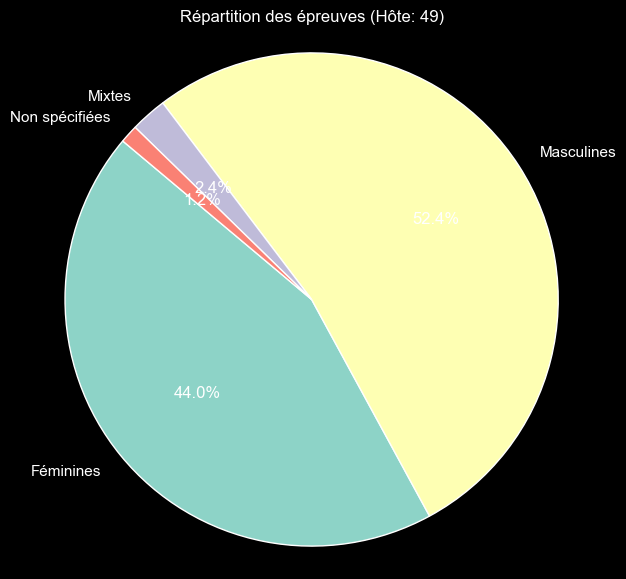

In [269]:
query = (
    f"SELECT "
    f"SUM(CASE WHEN e.NOMEVENEMENT LIKE '%Women%' THEN 1 ELSE 0 END) AS nb_epreuves_feminines, "
    f"SUM(CASE WHEN e.NOMEVENEMENT LIKE '%Men%' THEN 1 ELSE 0 END) AS nb_epreuves_masculines, "
    f"SUM(CASE WHEN e.NOMEVENEMENT LIKE '%Mixed%' THEN 1 ELSE 0 END) AS nb_epreuves_mixtes, "
    f"SUM(CASE WHEN e.NOMEVENEMENT NOT LIKE '%Women%' "
    f"AND e.NOMEVENEMENT NOT LIKE '%Men%' "
    f"AND e.NOMEVENEMENT NOT LIKE '%Mixed%' THEN 1 ELSE 0 END) AS nb_epreuves_non_specifiees "
    f"FROM EVENEMENT e "
    f"WHERE e.IDHOTE = 49"
)

data_epreuves = requete_vers_dataframe(conn, query)

if not data_epreuves.empty:
    labels = ['Féminines', 'Masculines', 'Mixtes', 'Non spécifiées']
    sizes = [
        data_epreuves.loc[0, 'NB_EPREUVES_FEMININES'],
        data_epreuves.loc[0, 'NB_EPREUVES_MASCULINES'],
        data_epreuves.loc[0, 'NB_EPREUVES_MIXTES'],
        data_epreuves.loc[0, 'NB_EPREUVES_NON_SPECIFIEES']
    ]
    
    plt.figure(figsize=(7, 7))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal') 
    plt.title('Répartition des épreuves (Hôte: 49)')
    plt.show()
else:
    print("Aucune donnée disponible pour générer le diagramme.")

### Comparaison du classement des differents session des jeux olympiques d'hiver

In [270]:
import seaborn as sns
import pandas as pd

def obtenir_classement_pays_par_edition(connexion, idhote):
    query = """
       SELECT
           CODE_NOC,
           POSITION_CLASSEMENT
       FROM (
           SELECT
               CODE_NOC,
               POSITION_CLASSEMENT
           FROM (
               SELECT
                   codenoc AS CODE_NOC,
                   RANK() OVER (ORDER BY NB_OR DESC, NB_ARGENT DESC, NB_BRONZE DESC, NB_TOTAL DESC, codenoc) AS POSITION_CLASSEMENT
               FROM (
                   SELECT
                       n.codenoc,
                       NVL(mi.NB_MEDAILLES_OR_INDIV, 0) + NVL(me.NB_MEDAILLES_OR_GROUP, 0) AS NB_OR,
                       NVL(mi.NB_MEDAILLES_ARGENT_INDIV, 0) + NVL(me.NB_MEDAILLES_ARGENT_GROUP, 0) AS NB_ARGENT,
                       NVL(mi.NB_MEDAILLES_BRONZE_INDIV, 0) + NVL(me.NB_MEDAILLES_BRONZE_GROUP, 0) AS NB_BRONZE,
                       (NVL(mi.NB_MEDAILLES_OR_INDIV, 0) + NVL(me.NB_MEDAILLES_OR_GROUP, 0) +
                        NVL(mi.NB_MEDAILLES_ARGENT_INDIV, 0) + NVL(me.NB_MEDAILLES_ARGENT_GROUP, 0) +
                        NVL(mi.NB_MEDAILLES_BRONZE_INDIV, 0) + NVL(me.NB_MEDAILLES_BRONZE_GROUP, 0)) AS NB_TOTAL
                   FROM noc n
                   LEFT JOIN (
                       SELECT
                           pi.noc,
                           SUM(CASE WHEN pi.medaille = 'Gold' THEN 1 ELSE 0 END) AS NB_MEDAILLES_OR_INDIV,
                           SUM(CASE WHEN pi.medaille = 'Silver' THEN 1 ELSE 0 END) AS NB_MEDAILLES_ARGENT_INDIV,
                           SUM(CASE WHEN pi.medaille = 'Bronze' THEN 1 ELSE 0 END) AS NB_MEDAILLES_BRONZE_INDIV
                       FROM participation_individuelle pi
                       INNER JOIN evenement ev ON pi.idevent = ev.idevenement
                       WHERE ev.idhote = :idhote
                       GROUP BY pi.noc
                   ) mi ON n.codenoc = mi.noc
                   LEFT JOIN (
                       SELECT
                           e.noc,
                           SUM(CASE WHEN pe.medaille = 'Gold' THEN 1 ELSE 0 END) AS NB_MEDAILLES_OR_GROUP,
                           SUM(CASE WHEN pe.medaille = 'Silver' THEN 1 ELSE 0 END) AS NB_MEDAILLES_ARGENT_GROUP,
                           SUM(CASE WHEN pe.medaille = 'Bronze' THEN 1 ELSE 0 END) AS NB_MEDAILLES_BRONZE_GROUP
                       FROM participation_equipe pe
                       INNER JOIN equipe e ON e.idequipe = pe.idequipe
                       INNER JOIN evenement ev ON pe.idevenement = ev.idevenement
                       WHERE ev.idhote = :idhote
                       GROUP BY e.noc
                   ) me ON n.codenoc = me.noc
               ) classement_int
               ORDER BY NB_OR DESC, NB_ARGENT DESC, NB_BRONZE DESC, NB_TOTAL DESC, codenoc
           )
       )
       WHERE POSITION_CLASSEMENT <= 5  -- Limite aux 5 premiers pays
    """
    params = {'idhote': idhote}
    return pd.read_sql(query, connexion, params=params)

data_classement_global = pd.DataFrame()
for idhote in range(29, 48):
    data_classement_temp = obtenir_classement_pays_par_edition(conn, idhote)
    data_classement_temp['EDITION'] = idhote
    data_classement_global = pd.concat([data_classement_global, data_classement_temp])

tableau_classement = data_classement_global.pivot(index='POSITION_CLASSEMENT', columns='EDITION', values='CODE_NOC').fillna('')

tableau_classement

/tmp/ipykernel_511/2573527448.py:57: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, connexion, params=params)
/tmp/ipykernel_511/2573527448.py:57: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, connexion, params=params)
/tmp/ipykernel_511/2573527448.py:57: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, connexion, params=params)
/tmp/ipykernel_511/2573527448.py:57: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or databas

EDITION,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
POSITION_CLASSEMENT,,,,,,,,,,,,,,,,,,,
1,NOR,NOR,USA,NOR,NOR,NOR,URS,URS,URS,NOR,URS,URS,URS,GDR,URS,GER,RUS,GER,NOR
2,FIN,USA,NOR,GER,SWE,USA,AUT,GER,AUT,URS,GDR,GDR,GDR,URS,GDR,EUN,NOR,NOR,GER
3,AUT,SWE,SWE,SWE,SUI,FIN,FIN,USA,NOR,FRA,SUI,USA,USA,USA,SUI,NOR,GER,RUS,USA
4,SUI,FIN,CAN,FIN,USA,GER,SUI,NOR,FIN,ITA,NED,NOR,AUT,FIN,FIN,AUT,ITA,CAN,CAN
5,USA,CAN,FIN,SUI,FRA,AUT,SWE,SWE,FRA,AUT,USA,FRG,SWE,SWE,SWE,USA,USA,USA,RUS


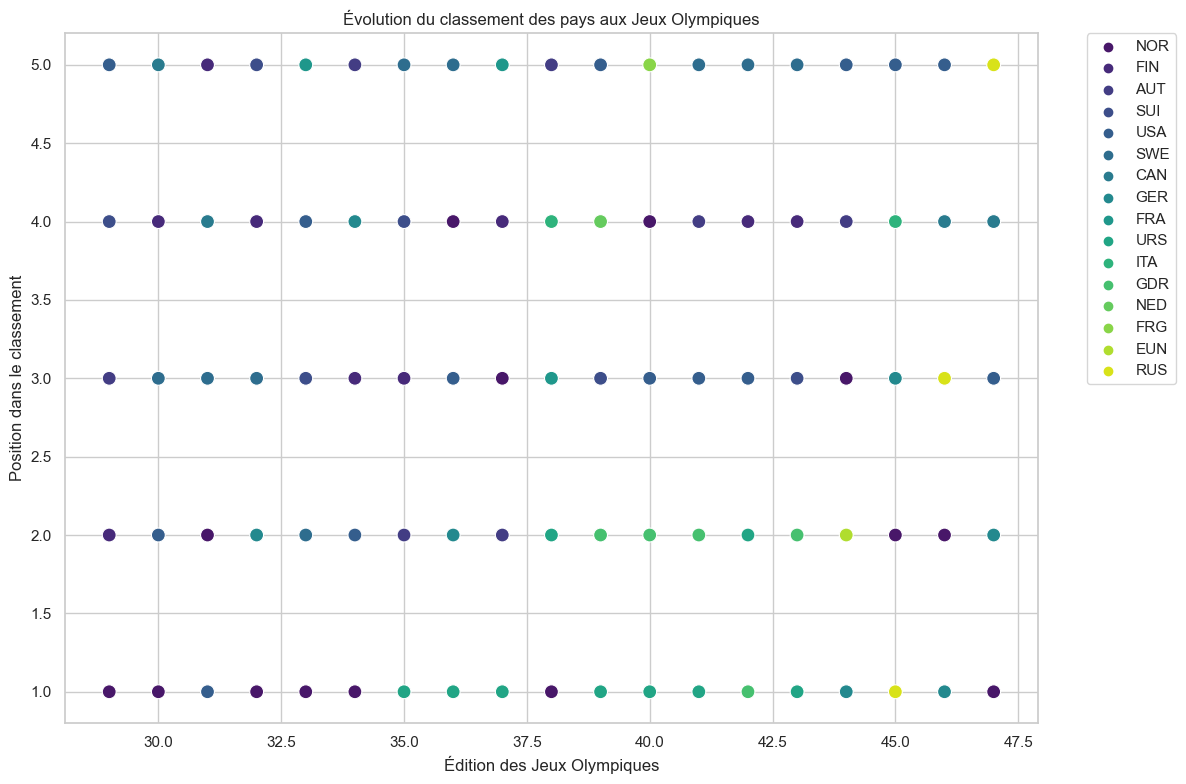

In [271]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(12, 8)) 

sns.scatterplot(data=data_classement_global, x='EDITION', y='POSITION_CLASSEMENT', hue='CODE_NOC',
                palette='viridis', legend='full', s=100)

plt.title('Évolution du classement des pays aux Jeux Olympiques')
plt.xlabel('Édition des Jeux Olympiques')
plt.ylabel('Position dans le classement')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.show()


Sur les différents graphiques tableaux ci-dessus nous pouvons observez un point amusant sur les pays qui sont le mieux classée, et comparer au jeux olympiques dété les USA ne sont pas souvent 1er comparer a la norvege et a l'urss, ceci est peut etre une des conséquence au mode de vie et aux temperatures des pays et de la population qui y vivent.

### La répartition des médailles selon le genre

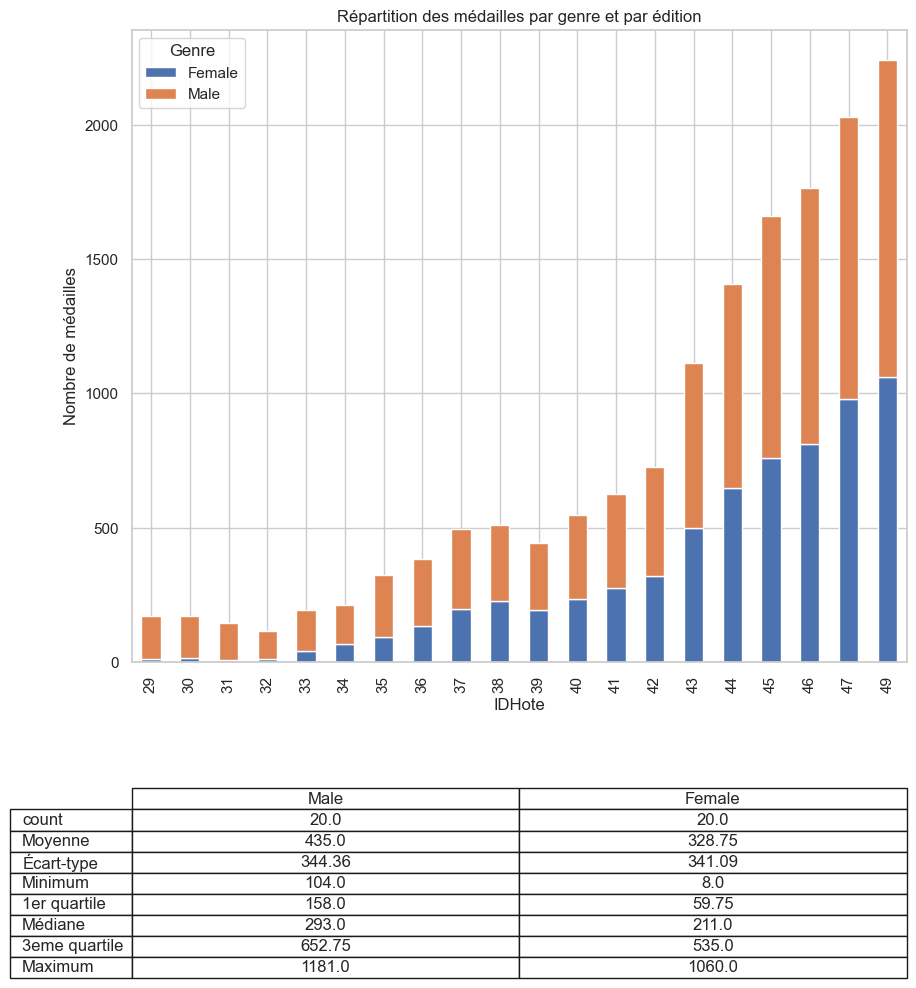

In [272]:
# Modify requete_vers_dataframe to return a DataFrame
def requete_vers_dataframe(connexion, query, params=None):
    cursor = connexion.cursor()
    if params:
        cursor.execute(query, params)
    else:
        cursor.execute(query)
    # Fetch all rows and convert to DataFrame
    rows = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    df = pd.DataFrame(rows, columns=columns)
    return df

# Modify obtenir_medailles_par_genre to pass idhote as a parameter
def obtenir_medailles_par_genre(connexion, idhote):
    query = f"""
        SELECT
            a.genre AS GENRE,
            SUM(ma.nb_total) AS TOTAL_MEDAILLES
        FROM
            {SCHEMA}.MEDAILLES_ATHLETES ma
            INNER JOIN {SCHEMA}.ATHLETE a ON ma.idathlete = a.idathlete
            INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE pi ON a.idathlete = pi.idathlete
            INNER JOIN {SCHEMA}.EVENEMENT e ON pi.idevent = e.idevenement
        WHERE
            e.idhote = :idhote
        GROUP BY
            a.genre
    """
    # Pass parameters dictionary to requete_vers_dataframe
    return requete_vers_dataframe(connexion, query, {'idhote': idhote})

data_medailles = pd.DataFrame()

# Iterate over idhote range
for idhote in range(29, 48):
    data_temp = obtenir_medailles_par_genre(conn, idhote)
    if 'GENRE' in data_temp.columns and 'TOTAL_MEDAILLES' in data_temp.columns:
        data_temp['idhote'] = idhote
        data_medailles = pd.concat([data_medailles, data_temp], ignore_index=True)
    else:
        print(f"Missing columns for idhote {idhote}: {data_temp.columns}")

# Fetch data for idhote 49 separately
data_actuel = obtenir_medailles_par_genre(conn, 49)
if 'GENRE' in data_actuel.columns and 'TOTAL_MEDAILLES' in data_actuel.columns:
    data_actuel['idhote'] = 49
    data_medailles = pd.concat([data_medailles, data_actuel], ignore_index=True)
else:
    print(f"Missing columns for idhote 49: {data_actuel.columns}")

# Pivot and process data as before
data_medailles_pivot = data_medailles.pivot(index='idhote', columns='GENRE', values='TOTAL_MEDAILLES').fillna(0)
data_medailles_pivot = data_medailles_pivot.reindex(columns=['Female', 'Male'])

statistiques_male = data_medailles_pivot['Male'].describe().rename(index={
    'mean': 'Moyenne', 'std': 'Écart-type', 'min': 'Minimum', '25%': '1er quartile',
    '50%': 'Médiane', '75%': '3eme quartile', 'max': 'Maximum'
})

statistiques_female = data_medailles_pivot['Female'].describe().rename(index={
    'mean': 'Moyenne', 'std': 'Écart-type', 'min': 'Minimum', '25%': '1er quartile',
    '50%': 'Médiane', '75%': '3eme quartile', 'max': 'Maximum'
})

statistiques = pd.concat([statistiques_male, statistiques_female], axis=1)
statistiques.columns = ['Male', 'Female']

statistiques = statistiques.round(2)

# Plotting and table rendering code remains unchanged
# Tracer le graphique avec une taille plus grande pour le tableau
fig, ax = plt.subplots(figsize=(10, 8))
data_medailles_pivot.plot(kind='bar', stacked=True, ax=ax)
plt.title('Répartition des médailles par genre et par édition')
plt.xlabel('IDHote')
plt.ylabel('Nombre de médailles')
plt.legend(title='Genre')

# Affichage des statistiques sous forme de tableau avec les noms en français
table = plt.table(cellText=statistiques.values,
                  rowLabels=statistiques.index,
                  colLabels=statistiques.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.5, 1, 0.3])  # Positionnement du tableau

# Ajuster la taille des cellules
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)

plt.subplots_adjust(bottom=0.09)  # Ajustement de la marge inférieure
plt.show()


### La répartition des médailles selon le pays

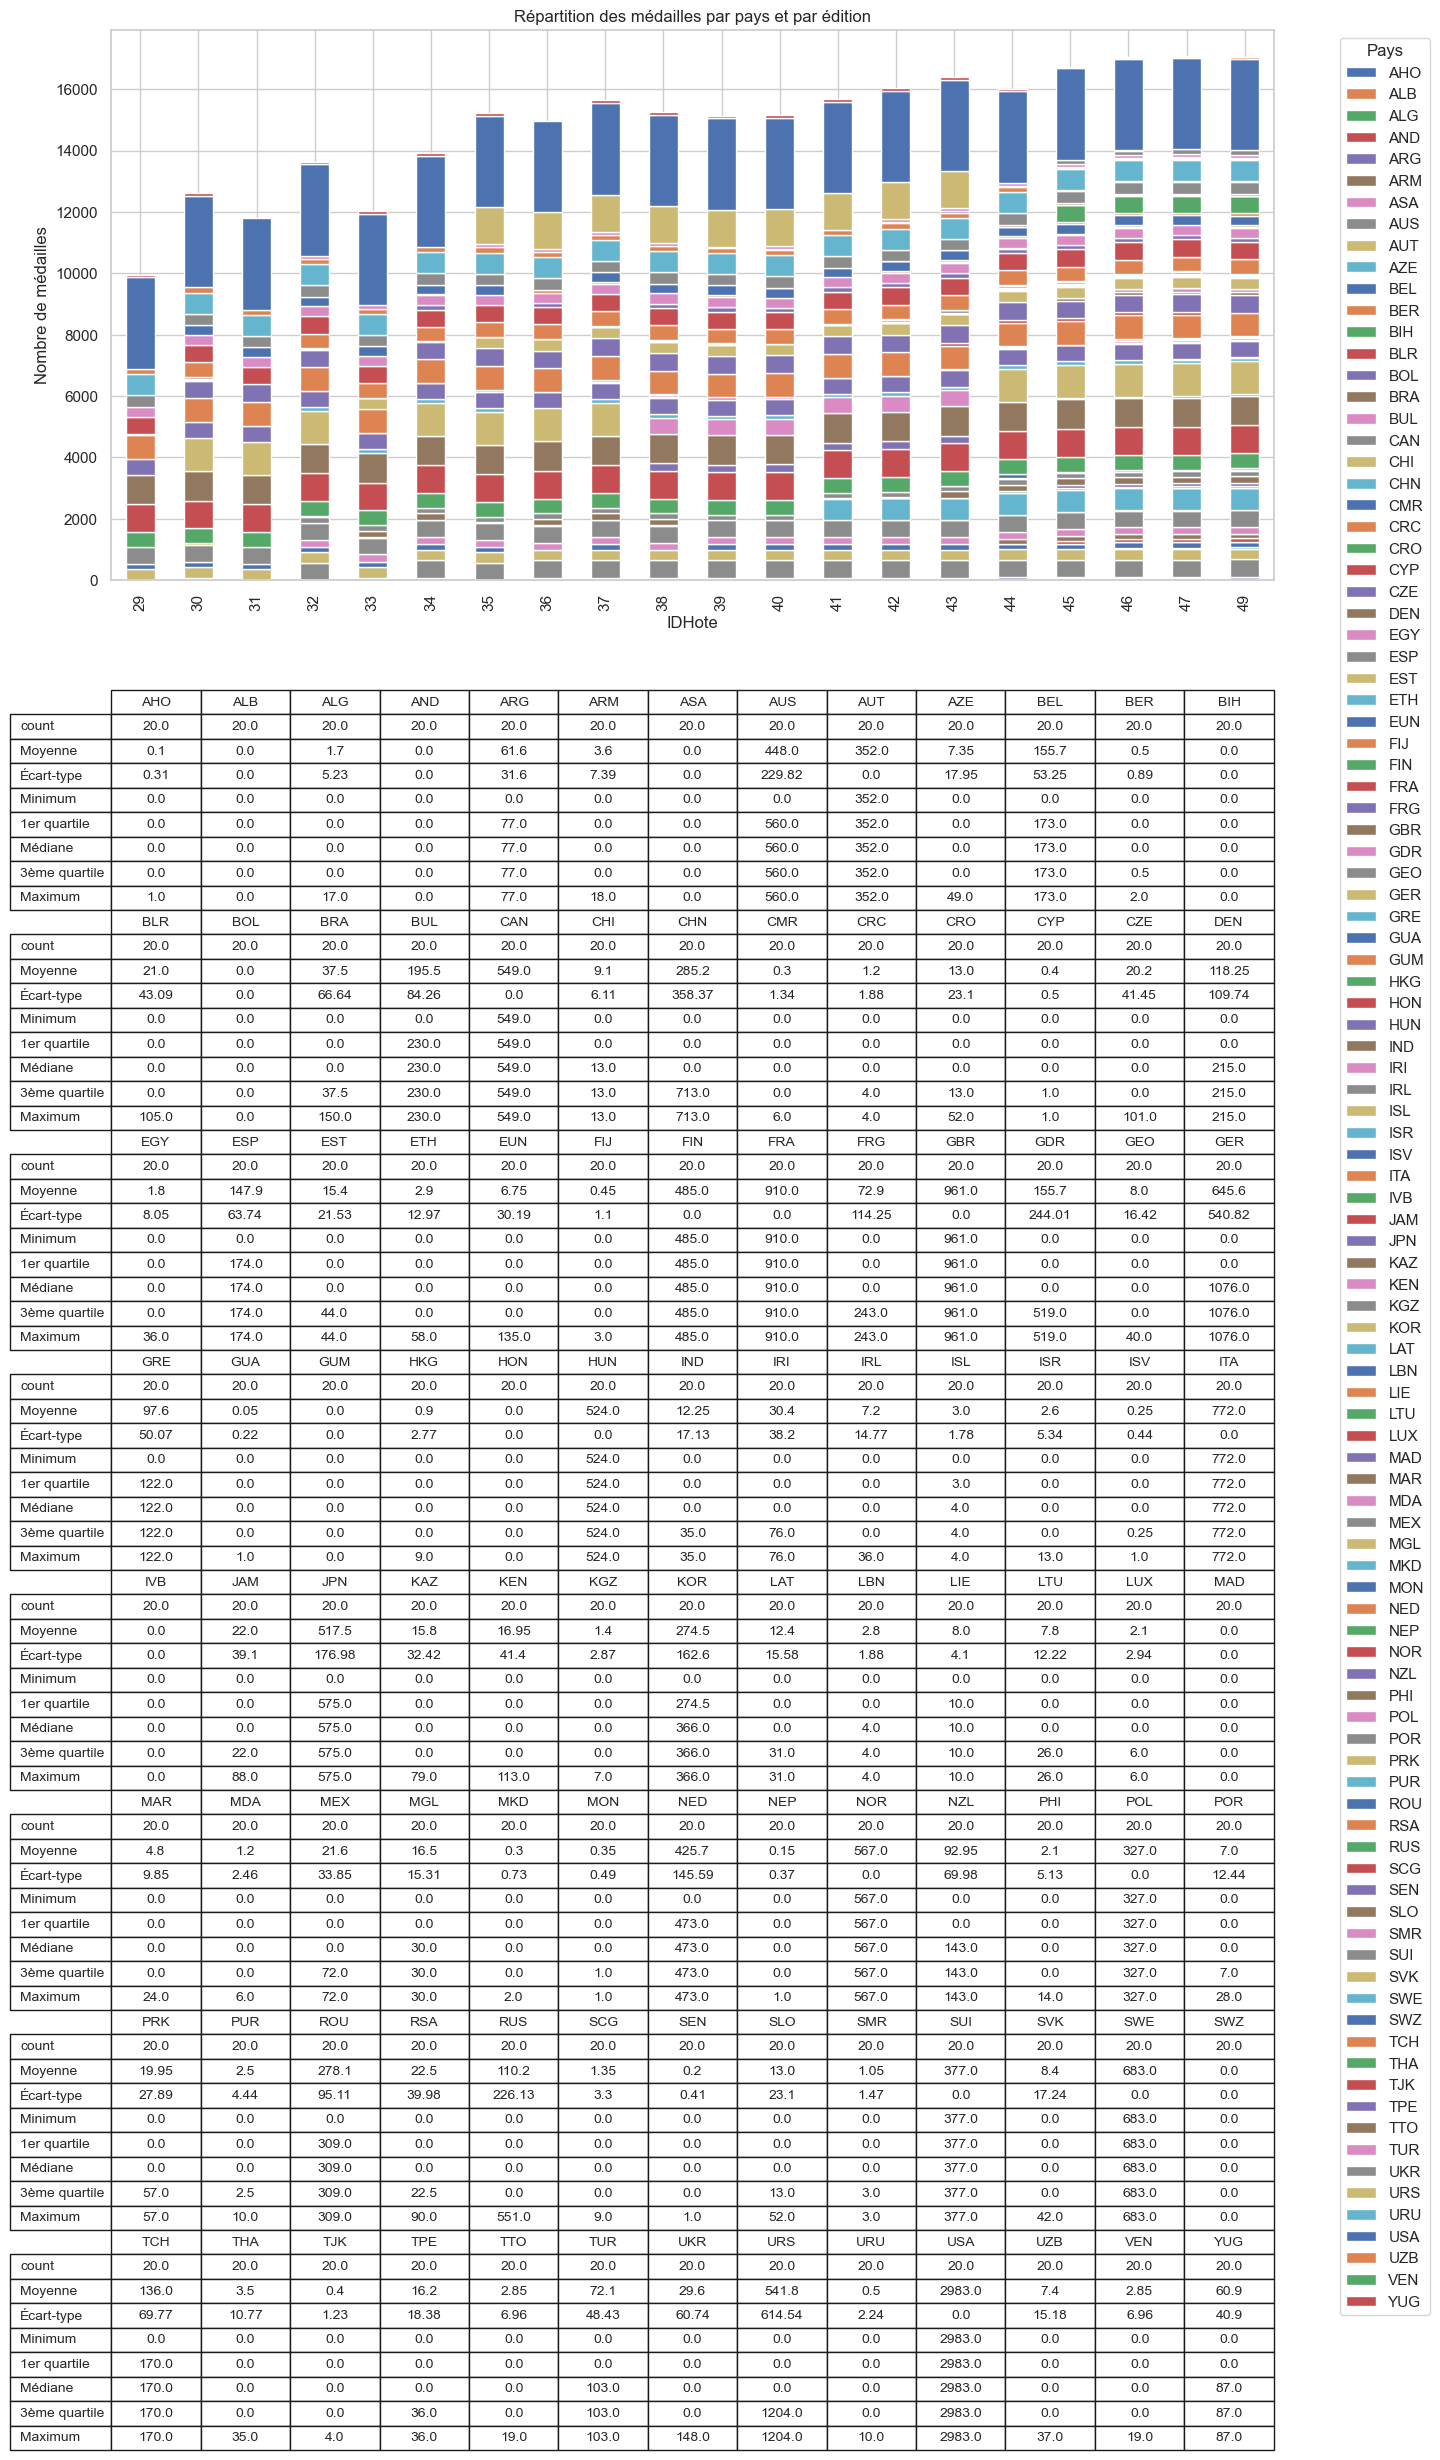

In [273]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Fonction pour exécuter une requête SQL et récupérer les résultats dans un DataFrame
def requete_vers_dataframe(connexion, requete, params=None):
    warnings.simplefilter(action='ignore', category=UserWarning)
    if params is None:
        df = pd.read_sql(requete, connexion)
    else:
        df = pd.read_sql(requete, connexion, params=params)
    return df

# Fonction pour obtenir les médailles par pays pour une édition donnée
def obtenir_medailles_par_pays(connexion, idhote):
    query = f"""
        SELECT
            mn.codenoc AS PAYS,
            mn.nb_total AS TOTAL_MEDAILLES
        FROM
            {SCHEMA}.MEDAILLES_NOC mn
        WHERE
            mn.codenoc IN (
                SELECT DISTINCT n.codenoc
                FROM {SCHEMA}.NOC n
                JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE pi ON n.codenoc = pi.noc
                JOIN {SCHEMA}.EVENEMENT e ON pi.idevent = e.idevenement
                WHERE e.idhote = :idhote
                UNION
                SELECT DISTINCT n.codenoc
                FROM {SCHEMA}.NOC n
                JOIN {SCHEMA}.EQUIPE eq ON n.codenoc = eq.noc
                JOIN {SCHEMA}.PARTICIPATION_EQUIPE pe ON eq.idequipe = pe.idequipe
                JOIN {SCHEMA}.EVENEMENT e ON pe.idevenement = e.idevenement
                WHERE e.idhote = :idhote
            )
    """
    params = {'idhote': idhote}
    return requete_vers_dataframe(connexion, query, params)



# Collecte des données pour toutes les éditions historiques (29 à 47)
data_medailles = pd.DataFrame()
for idhote in range(29, 48):
    data_temp = obtenir_medailles_par_pays(conn, idhote)
    if 'PAYS' in data_temp.columns and 'TOTAL_MEDAILLES' in data_temp.columns:
        data_temp['idhote'] = idhote
        data_medailles = pd.concat([data_medailles, data_temp], ignore_index=True)
    else:
        print(f"Missing columns for idhote {idhote}: {data_temp.columns}")

# Ajouter les données pour l'édition actuelle (idhote 49)
data_actuel = obtenir_medailles_par_pays(conn, 49)
if 'PAYS' in data_actuel.columns and 'TOTAL_MEDAILLES' in data_actuel.columns:
    data_actuel['idhote'] = 49
    data_medailles = pd.concat([data_medailles, data_actuel], ignore_index=True)
else:
    print(f"Missing columns for idhote 49: {data_actuel.columns}")

# Pivotage des données pour obtenir une vue par édition et par pays
data_medailles_pivot = data_medailles.pivot(index='idhote', columns='PAYS', values='TOTAL_MEDAILLES').fillna(0)

# Calcul des statistiques descriptives
statistiques = data_medailles_pivot.describe().rename(index={
    'mean': 'Moyenne', 'std': 'Écart-type', 'min': 'Minimum', '25%': '1er quartile',
    '50%': 'Médiane', '75%': '3ème quartile', 'max': 'Maximum'
}).round(2)

# Affichage du graphique
fig, ax = plt.subplots(figsize=(15, 10))
data_medailles_pivot.plot(kind='bar', stacked=True, ax=ax)
plt.title('Répartition des médailles par pays et par édition')
plt.xlabel('IDHote')
plt.ylabel('Nombre de médailles')
plt.legend(title='Pays', bbox_to_anchor=(1.05, 1), loc='upper left')

# Division des colonnes en groupes pour l'affichage des statistiques
n = 13
cols = statistiques.columns
groups = [cols[i:i + n] for i in range(0, len(cols), n)]

# Affichage des statistiques sous forme de tableau
for i, group in enumerate(groups):
    table = plt.table(cellText=statistiques[group].values,
                      rowLabels=statistiques.index,
                      colLabels=group,
                      cellLoc='center',
                      loc='bottom',
                      bbox=[0, -0.6 - (i * 0.4), 1, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.5, 1.5)

# Ajustement de la position du tableau pour un meilleur agencement
plt.subplots_adjust(bottom=0.09 + (len(groups) * 0.03)) 
plt.show()


Ce graphique permet d'observer seulement l'augmentation et la popularisation des jeux olympiques d'hiver dans le monde ce qui par conséquent augmente le 
nombre de participant, d'épreuve, et de médailles.

### Le nombre de femmes par éditions

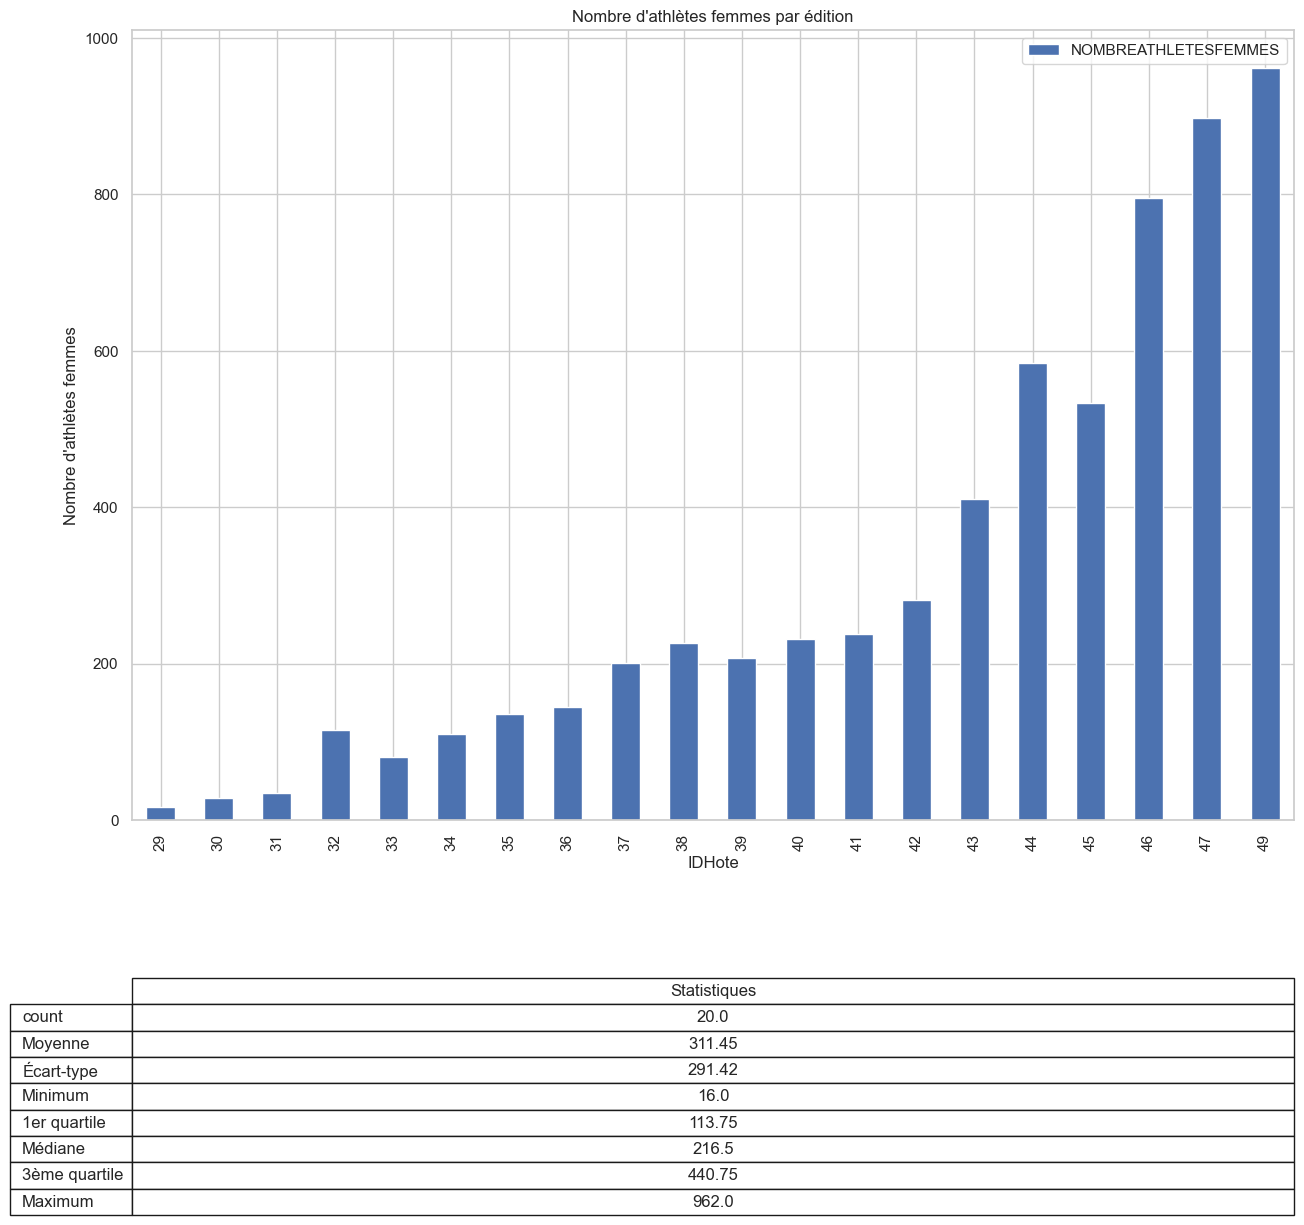

In [274]:
def obtenir_nombre_athletes_femmes(connexion, idhote):
    query = f"""
        SELECT COUNT(DISTINCT ath.IDATHLETE) AS NombreAthletesFemmes
        FROM (
            SELECT a.IDATHLETE
            FROM {SCHEMA}.PARTICIPATION_INDIVIDUELLE pi
            JOIN {SCHEMA}.ATHLETE a ON pi.IDATHLETE = a.IDATHLETE
            JOIN {SCHEMA}.EVENEMENT e ON pi.IDEVENT = e.IDEVENEMENT
            JOIN {SCHEMA}.HOTE h ON e.IDHOTE = h.IDHOTE
            WHERE a.GENRE = 'Female'
            AND h.IDHOTE = :idhote

            UNION

            SELECT ce.IDATHLETE
            FROM {SCHEMA}.COMPOSITION_EQUIPE ce
            JOIN {SCHEMA}.EQUIPE eq ON ce.IDEQUIPE = eq.IDEQUIPE
            JOIN {SCHEMA}.PARTICIPATION_EQUIPE pe ON eq.IDEQUIPE = pe.IDEQUIPE
            JOIN {SCHEMA}.EVENEMENT ev ON pe.IDEVENEMENT = ev.IDEVENEMENT
            JOIN {SCHEMA}.HOTE ho ON ev.IDHOTE = ho.IDHOTE
            JOIN {SCHEMA}.ATHLETE ath ON ce.IDATHLETE = ath.IDATHLETE
            WHERE ath.GENRE = 'Female'
            AND ho.IDHOTE = :idhote
        ) ath
    """
    return requete_vers_dataframe(connexion, query,{'idhote': idhote})


data_athletes_femmes = pd.DataFrame()
for idhote in range(29, 48): 
    data_temp = obtenir_nombre_athletes_femmes(conn, idhote)
    if 'NOMBREATHLETESFEMMES' in data_temp.columns:
        data_temp['idhote'] = idhote
        data_athletes_femmes = pd.concat([data_athletes_femmes, data_temp], ignore_index=True)
    else:
        print(f"Missing columns for idhote {idhote}: {data_temp.columns}")

data_actuel = obtenir_nombre_athletes_femmes(conn, 49)
if 'NOMBREATHLETESFEMMES' in data_actuel.columns:
    data_actuel['idhote'] = 49
    data_athletes_femmes = pd.concat([data_athletes_femmes, data_actuel], ignore_index=True)
else:
    print(f"Missing columns for idhote 49: {data_actuel.columns}")


if 'idhote' in data_athletes_femmes.columns:
    data_athletes_femmes.set_index('idhote', inplace=True)
else:
    print("La colonne 'idhote' est manquante dans les données finales.")

if 'NOMBREATHLETESFEMMES' in data_athletes_femmes.columns:
    statistiques_athletes_femmes = data_athletes_femmes['NOMBREATHLETESFEMMES'].describe().rename(index={
        'mean': 'Moyenne', 'std': 'Écart-type', 'min': 'Minimum', '25%': '1er quartile',
        '50%': 'Médiane', '75%': '3ème quartile', 'max': 'Maximum'
    })

    statistiques_athletes_femmes = statistiques_athletes_femmes.round(2)

    fig, ax = plt.subplots(figsize=(15, 10))
    data_athletes_femmes.plot(kind='bar', ax=ax)
    plt.title('Nombre d\'athlètes femmes par édition')
    plt.xlabel('IDHote')
    plt.ylabel('Nombre d\'athlètes femmes')

    table = plt.table(cellText=statistiques_athletes_femmes.values.reshape(-1, 1),
                      rowLabels=statistiques_athletes_femmes.index,
                      colLabels=['Statistiques'],
                      cellLoc='center',
                      loc='bottom',
                      bbox=[0, -0.5, 1, 0.3]) 

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 1.5)

    plt.subplots_adjust(bottom=0.09) 
    plt.show()
else:
    print("La colonne 'NombreAthletesFemmes' est manquante dans les données finales.")


Sur ce graphique nous pouvons observez une grande amélioration du nombre d'athlète feminin dans les jeux olympiques, ceci surement du a une réduction du sexisme et la 
popularisation du Sport feminin.

### La moyenne d'âge des participants pour chaque édition

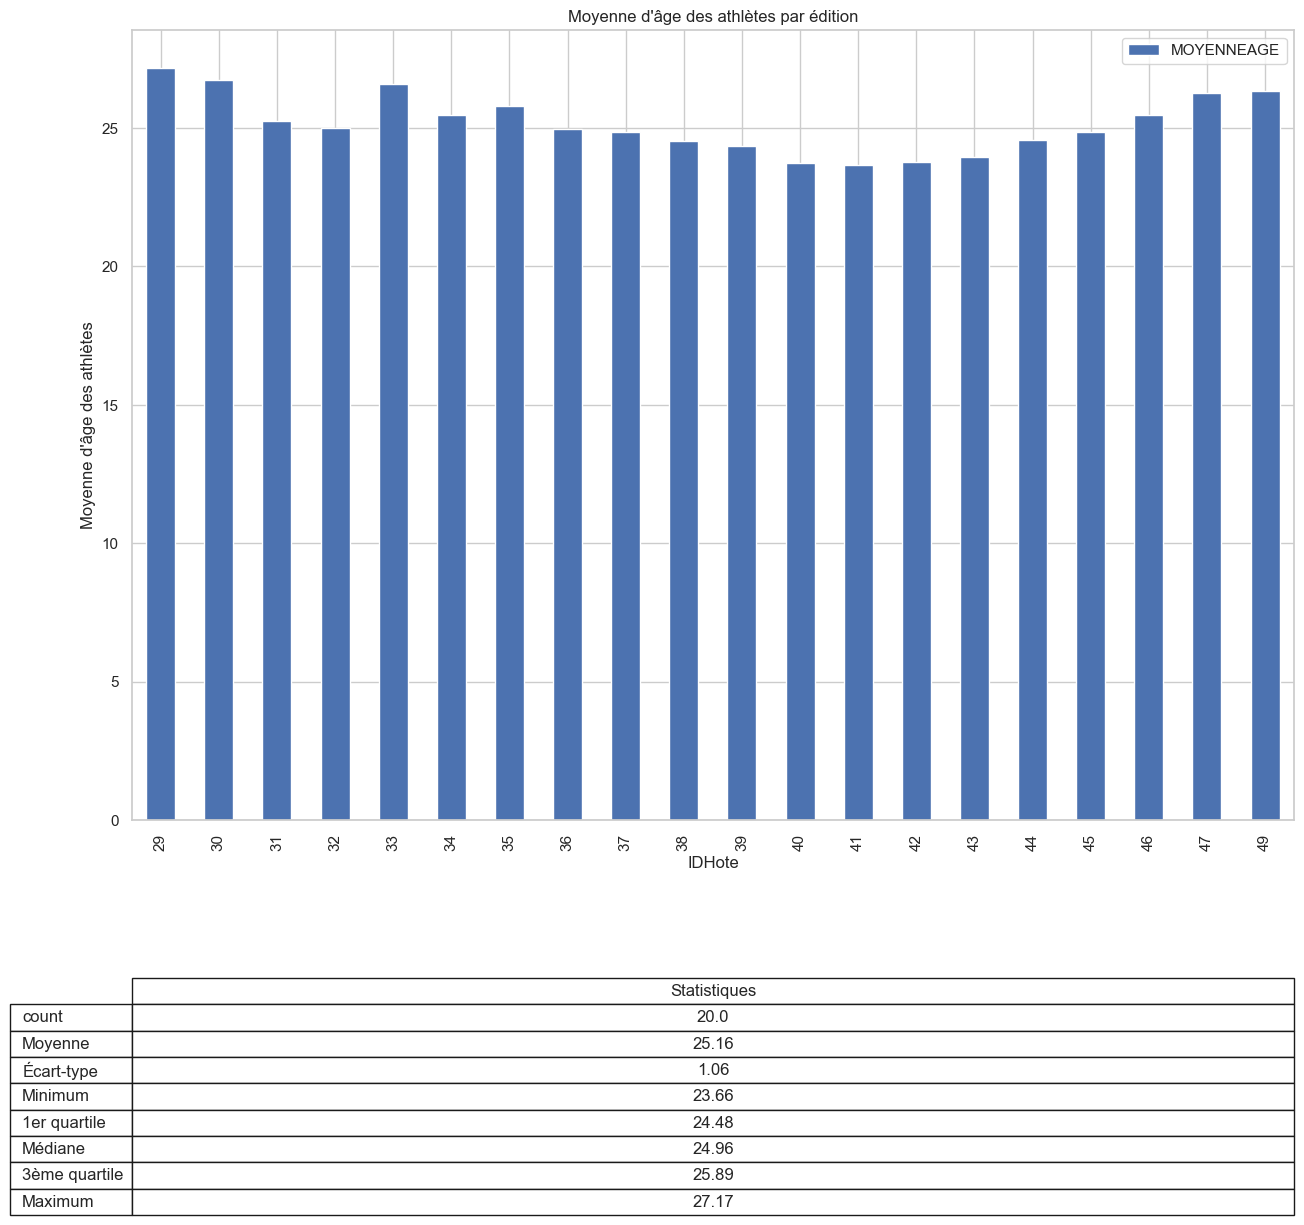

In [275]:

def obtenir_moyenne_age(connexion, idhote):
    query = f"""
        SELECT AVG(h.anneehote - EXTRACT(YEAR FROM a.DATENAISSANCE)) AS MoyenneAge
        FROM {SCHEMA}.ATHLETE a
        JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE pi ON a.IDATHLETE = pi.IDATHLETE
        JOIN {SCHEMA}.EVENEMENT e ON pi.IDEVENT = e.IDEVENEMENT
        JOIN {SCHEMA}.HOTE h ON e.IDHOTE = h.IDHOTE
        WHERE h.IDHOTE = :idhote
    """
    return requete_vers_dataframe(connexion, query, {'idhote': idhote})

data_moyenne_age = pd.DataFrame()
for idhote in range(29, 48): 
    data_temp = obtenir_moyenne_age(conn, idhote)
    if 'MOYENNEAGE' in data_temp.columns:
        data_temp['idhote'] = idhote
        data_moyenne_age = pd.concat([data_moyenne_age, data_temp], ignore_index=True)
    else:
        print(f"Missing columns for idhote {idhote}: {data_temp.columns}")

data_actuel = obtenir_moyenne_age(conn, 49)
if 'MOYENNEAGE' in data_actuel.columns:
    data_actuel['idhote'] = 49
    data_moyenne_age = pd.concat([data_moyenne_age, data_actuel], ignore_index=True)
else:
    print(f"Missing columns for idhote 49: {data_actuel.columns}")

if 'idhote' in data_moyenne_age.columns:
    data_moyenne_age.set_index('idhote', inplace=True)
else:
    print("La colonne 'idhote' est manquante dans les données finales.")

if 'MOYENNEAGE' in data_moyenne_age.columns:
    statistiques_moyenne_age = data_moyenne_age['MOYENNEAGE'].describe().rename(index={
        'mean': 'Moyenne', 'std': 'Écart-type', 'min': 'Minimum', '25%': '1er quartile',
        '50%': 'Médiane', '75%': '3ème quartile', 'max': 'Maximum'
    })

    statistiques_moyenne_age = statistiques_moyenne_age.round(2)

    fig, ax = plt.subplots(figsize=(15, 10))
    data_moyenne_age.plot(kind='bar', ax=ax)
    plt.title('Moyenne d\'âge des athlètes par édition')
    plt.xlabel('IDHote')
    plt.ylabel('Moyenne d\'âge des athlètes')

    table = plt.table(cellText=statistiques_moyenne_age.values.reshape(-1, 1),
                      rowLabels=statistiques_moyenne_age.index,
                      colLabels=['Statistiques'],
                      cellLoc='center',
                      loc='bottom',
                      bbox=[0, -0.5, 1, 0.3]) 

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 1.5)

    plt.subplots_adjust(bottom=0.09)  
    plt.show()
else:
    print("La colonne 'MOYENNEAGE' est manquante dans les données finales.")

Nous pouvons observez une moyenne d'age qui est trés constante tout au long des differentes session de jeux olympiques d'hiver et qui ne change pas meme pour la session des jeux olympiques de Turin en Italie

### Evolution des 3 meilleurs pays durant les jeux olympiques d'hiver

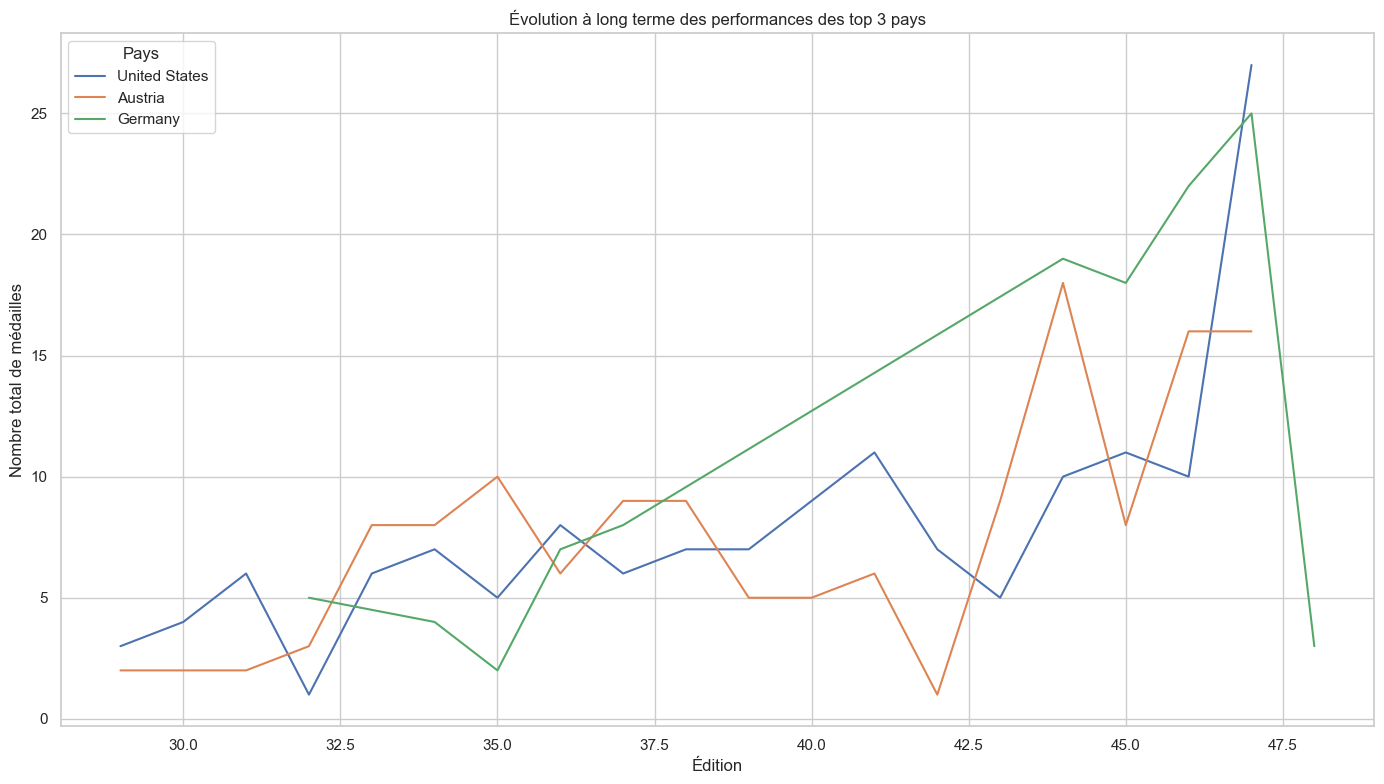

In [276]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

def requete_vers_dataframe(connexion, requete):
    warnings.simplefilter(action='ignore', category=UserWarning)
    df = pd.read_sql(requete, connexion)
    return df

def obtenir_medailles_par_pays(connexion, idhote):
    query = f"""
        SELECT
            noc.nomnoc AS PAYS,
            noc.codenoc AS CODE_NOC,
            pi.medaille AS COULEUR,
            COUNT(pi.medaille) AS NOMBRE
        FROM
            {SCHEMA}.PARTICIPATION_INDIVIDUELLE pi
            INNER JOIN {SCHEMA}.ATHLETE a ON pi.idathlete = a.idathlete
            INNER JOIN {SCHEMA}.EVENEMENT e ON pi.idevent = e.idevenement
            INNER JOIN {SCHEMA}.NOC noc ON pi.noc = noc.codenoc
        WHERE
            e.idhote = {idhote}
        GROUP BY
            noc.nomnoc, noc.codenoc, pi.medaille
    """
    return requete_vers_dataframe(connexion, query)

data_actuel_pays = obtenir_medailles_par_pays(conn, 49)

tableau_actuel_medailles = data_actuel_pays.pivot_table(index=['PAYS', 'CODE_NOC'], columns='COULEUR', values='NOMBRE', aggfunc='sum', fill_value=0)

tableau_actuel_medailles['TOTAL'] = tableau_actuel_medailles.sum(axis=1)

top_3_pays = tableau_actuel_medailles.sort_values(by='TOTAL', ascending=False).head(3)
top_3_nocs = top_3_pays.index.get_level_values('CODE_NOC').tolist()


def obtenir_medailles_pays_historiques(connexion, idhotes, nocs):
    idhotes_str = ', '.join(map(str, idhotes))
    nocs_str = ', '.join([f"'{noc}'" for noc in nocs])
    query = f"""
        SELECT
            e.idhote AS EDITION,
            noc.nomnoc AS PAYS,
            noc.codenoc AS CODE_NOC,
            pi.medaille AS COULEUR,
            COUNT(pi.medaille) AS NOMBRE
        FROM
            {SCHEMA}.PARTICIPATION_INDIVIDUELLE pi
            INNER JOIN {SCHEMA}.ATHLETE a ON pi.idathlete = a.idathlete
            INNER JOIN {SCHEMA}.EVENEMENT e ON pi.idevent = e.idevenement
            INNER JOIN {SCHEMA}.NOC noc ON pi.noc = noc.codenoc
        WHERE
            e.idhote IN ({idhotes_str})
            AND noc.codenoc IN ({nocs_str})
        GROUP BY
            e.idhote, noc.nomnoc, noc.codenoc, pi.medaille
    """
    return requete_vers_dataframe(connexion, query)

past_editions = range(29, 49)
data_historiques = obtenir_medailles_pays_historiques(conn, past_editions, top_3_nocs)

tableau_historiques_medailles = data_historiques.pivot_table(index=['EDITION', 'PAYS', 'CODE_NOC'], columns='COULEUR', values='NOMBRE', aggfunc='sum', fill_value=0)

tableau_historiques_medailles['TOTAL'] = tableau_historiques_medailles.sum(axis=1)

tableau_historiques_medailles_reset = tableau_historiques_medailles.reset_index()

fig, ax = plt.subplots(figsize=(14, 8))
for noc in top_3_nocs:
    country_data = tableau_historiques_medailles_reset[tableau_historiques_medailles_reset['CODE_NOC'] == noc]
    
    ax.plot(country_data['EDITION'], country_data['TOTAL'], label=country_data.iloc[0]['PAYS'])

plt.title('Évolution à long terme des performances des top 3 pays')
plt.xlabel('Édition')
plt.ylabel('Nombre total de médailles')
plt.legend(title='Pays')
plt.grid(True)

plt.tight_layout()
plt.show()


Sur le diagramme ci dessus nous pouvons admirrez les differentes équipes du top 3 des Jeux olympiques de Turin en Italie et leur Historique sur les précédents jeux olympiques
petite observation sur l'allemagne qui n'a étonnamment pas participer pendant les premières éditions (humour noir)
autre observation sur les états Unis qui ont compris que participer aux jeux olympiques pouvait aider à la publiciter de leur pays !
Tout ceci est bien sûr du second degrès.

# Présentation d'une équipe

### Performance de la France durant les différentes édition des Jeux Olympiques d'hiver 

### Moyenne d'athlete aux différentes éditions :

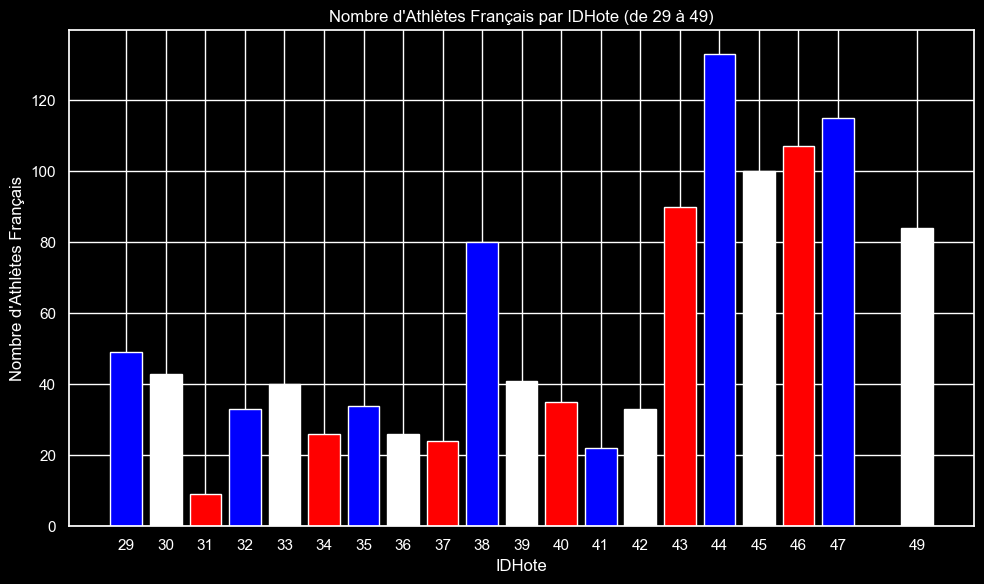

In [277]:
import matplotlib.pyplot as plt
import numpy as np

# Fonction pour récupérer le nombre d'athlètes français pour un idhote donné

def get_athlete_count(conn, idhote):
    query = """
        select count(*) as nombreathlete
        from (
            (select a.idathlete
             from athlete a
             inner join participation_individuelle pi on pi.idathlete = a.idathlete
             inner join evenement e on e.idevenement = pi.idevent
             inner join hote h on h.idhote = e.idhote
             where h.idhote = :hote and pi.noc = 'FRA')

            union

            (select a.idathlete 
             from athlete a
             inner join composition_equipe ce on ce.idathlete = a.idathlete
             inner join participation_equipe pe on pe.idequipe = ce.idequipe
             inner join equipe e on e.idequipe = pe.idequipe
             inner join evenement ev on ev.idevenement = pe.idevenement
             inner join hote h on h.idhote = ev.idhote
             where h.idhote = :hote and e.noc = 'FRA')
        )
    """
    cursor = conn.cursor()
    cursor.execute(query, {'hote': idhote})
    result = cursor.fetchone()
    return result[0] if result else 0

# Récupérer les moyennes pour chaque idhote entre 29 et 47
idhotes = [idhote for idhote in range(29, 50) if idhote != 48]
athlete_counts = [get_athlete_count(conn, idhote) for idhote in idhotes]

# Calculer la moyenne des athlètes pour chaque idhote
moyennes = np.mean(athlete_counts)

colors = ['blue', 'white', 'red'] * (len(idhotes) // 3) + ['blue', 'white', 'red'][:len(idhotes) % 3]

plt.style.use('dark_background')
# Créer le diagramme en colonnes avec matplotlib
plt.figure(figsize=(10, 6))
plt.bar(idhotes, athlete_counts, color=colors)
plt.xlabel('IDHote')
plt.ylabel('Nombre d\'Athlètes Français')
plt.title('Nombre d\'Athlètes Français par IDHote (de 29 à 49)')
plt.xticks(idhotes)
plt.tight_layout()
plt.show()



### Moyenne d'athlete médaillées/médailles par éditions

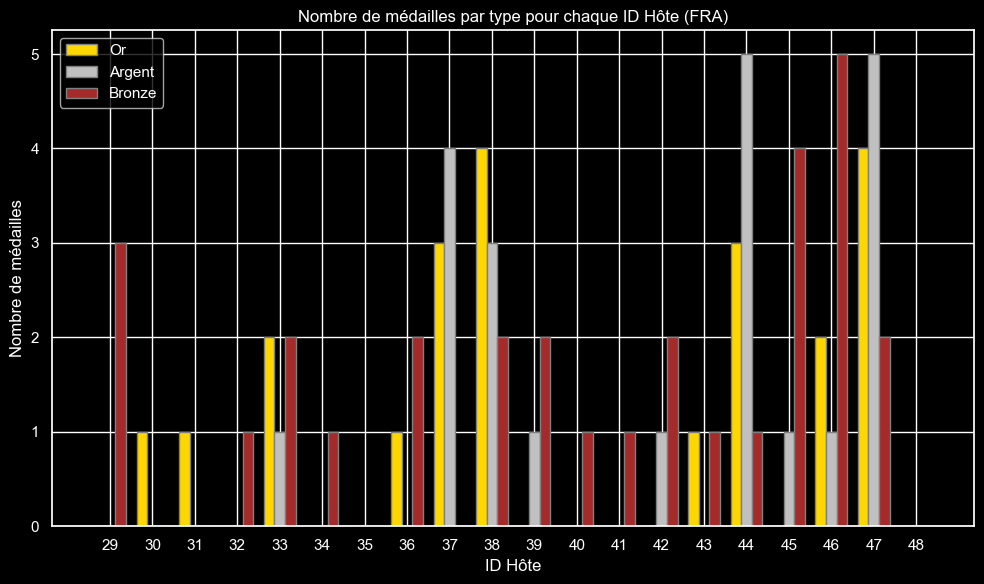

In [278]:

import matplotlib.pyplot as plt
import numpy as np


def get_medal_count(conn, idhote):
    query = """
           SELECT
       NVL(mi.NB_MEDAILLES_OR_INDIV, 0) + NVL(me.NB_MEDAILLES_OR_GROUP, 0) AS NB_OR,
       NVL(mi.NB_MEDAILLES_ARGENT_INDIV, 0) + NVL(me.NB_MEDAILLES_ARGENT_GROUP, 0) AS NB_ARGENT,
       NVL(mi.NB_MEDAILLES_BRONZE_INDIV, 0) + NVL(me.NB_MEDAILLES_BRONZE_GROUP, 0) AS NB_BRONZE
   FROM noc n
   LEFT JOIN (
       SELECT
           pi.noc,
           SUM(CASE WHEN pi.medaille = 'Gold' THEN 1 ELSE 0 END) AS NB_MEDAILLES_OR_INDIV,
           SUM(CASE WHEN pi.medaille = 'Silver' THEN 1 ELSE 0 END) AS NB_MEDAILLES_ARGENT_INDIV,
           SUM(CASE WHEN pi.medaille = 'Bronze' THEN 1 ELSE 0 END) AS NB_MEDAILLES_BRONZE_INDIV
       FROM participation_individuelle pi
       INNER JOIN evenement ev ON pi.idevent = ev.idevenement
       WHERE ev.idhote = :idhote and pi.noc = 'FRA'
       GROUP BY pi.noc
   ) mi ON n.codenoc = mi.noc
   LEFT JOIN (
       SELECT
           e.noc,
           SUM(CASE WHEN pe.medaille = 'Gold' THEN 1 ELSE 0 END) AS NB_MEDAILLES_OR_GROUP,
           SUM(CASE WHEN pe.medaille = 'Silver' THEN 1 ELSE 0 END) AS NB_MEDAILLES_ARGENT_GROUP,
           SUM(CASE WHEN pe.medaille = 'Bronze' THEN 1 ELSE 0 END) AS NB_MEDAILLES_BRONZE_GROUP
       FROM participation_equipe pe
       INNER JOIN equipe e ON e.idequipe = pe.idequipe
       INNER JOIN evenement ev ON pe.idevenement = ev.idevenement
       WHERE ev.idhote = :idhote and e.noc = 'FRA'
       GROUP BY e.noc
   ) me ON n.codenoc = me.noc
   where codenoc = 'FRA'
    """
   
    cursor = conn.cursor()
    cursor.execute(query, {'idhote': idhote})
    
  
    row = cursor.fetchone()
    cursor.close()

    return row


idhotes = range(29, 49) 
nb_or = []
nb_argent = []
nb_bronze = []

for idhote in idhotes:
   
    medal_counts = get_medal_count(conn, idhote)
    nb_or.append(medal_counts[0])
    nb_argent.append(medal_counts[1])
    nb_bronze.append(medal_counts[2])

plt.figure(figsize=(10, 6))
bar_width = 0.25


r1 = range(len(idhotes))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]


plt.bar(r1, nb_or, color='gold', width=bar_width, edgecolor='grey', label='Or')
plt.bar(r2, nb_argent, color='silver', width=bar_width, edgecolor='grey', label='Argent')
plt.bar(r3, nb_bronze, color='brown', width=bar_width, edgecolor='grey', label='Bronze')

plt.xlabel('ID Hôte')
plt.ylabel('Nombre de médailles')
plt.title('Nombre de médailles par type pour chaque ID Hôte (FRA)')
plt.xticks([r + bar_width for r in range(len(idhotes))], idhotes)
plt.legend()


plt.tight_layout()
plt.show()


## Analyse de la FRANCE !

Sur la première partie des diagrammes ci dessus nous pouvons observer un constante augmentation du nombre d'athlete jusqu'a un certain moment ou nous observons 
un palier qui stagne. Cepandant un point a observer est la constante augmentation du nombre de médailles que ce soit or argent ou bronze.
On peut en déduire/espérer que dans les prochains jeux olympiques qui ce passeront en 2010 à Vancouver la France ce dépassera comme jamais !

Répartition du travaille :
* Carnet numéro 1: 
    * Consultation des données - Yusra
    * Modification des données 
        * Résultats des médailles - Nicolas
        * Vérifications - Yusra
* Carnet numéro 2:
    * Présentation générale de l'édition des JO
        * Contexte/Nombre de fois/Ville et pays/Sites épreuves - Nicolas
        * Grande Statistiques/Répartition par Genre - Sanaâ
    * Comparaison de cette édition avec les éditions qui l'ont précédée
        * Classement des nations - Nicolas
        * Répartition des médailles - Sanaâ
        * évolution à long terme pour le top 3 - Nicolas
        * Moyennes d'ages athletes - Sanaâ
        * Féminisation - Sanaâ
    * Performance de l'équipe de votre choix - Nicolas
* Mise en page présentation - Nicolas